In this notbook I am testing this the model from this tatuial about multi-label classification [link](https://www.depends-on-the-definition.com/classifying-genres-of-movies-by-looking-at-the-poster-a-neural-approach/)
But, I couldn't get their result even by same code.


In [2]:
import numpy as np
import pandas as pd
import glob
import scipy.misc
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from tqdm import tqdm


In [3]:
path = '/home/zaher/DataFolder/posters'
data = pd.read_csv("/home/zaher/DataFolder/MovieGenre.csv", encoding="ISO-8859-1")


In [4]:
data.head()


,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation|Adventure|Comedy,https://images-na.ssl-images-amazon.com/images...
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action|Adventure|Family,https://images-na.ssl-images-amazon.com/images...
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,Comedy|Romance,https://images-na.ssl-images-amazon.com/images...
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,Comedy|Drama|Romance,https://images-na.ssl-images-amazon.com/images...
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,Comedy|Family|Romance,https://images-na.ssl-images-amazon.com/images...


In [5]:
image_glob = glob.glob(path + "/" + "*.jpg")
img_dict = {}


def get_id(filename):
    index_s = filename.rfind("/") + 1
    index_f = filename.rfind(".jpg")
    return filename[index_s:index_f]

In [6]:
c=0
for fn in tqdm(image_glob):
    try:
        img=cv2.imread(fn)
        if img is None:
            print(fn)
            c+=1
            continue
        img_dict[get_id(fn)] = img
    except Exception as r:
        print(r)
print(c)

100%|██████████| 38667/38667 [00:23<00:00, 1665.04it/s]

0


In [30]:
def show_img(id):
    title = data[data["imdbId"] == int(id)]["Title"].values[0]
    genre = data[data["imdbId"] == int(id)]["Genre"].values[0]
    img=img_dict[id]
    img=preprocess(img)
    print(img.shape)
    plt.imshow(img)
    plt.title("{} \n {}".format(title, genre))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(150, 101, 3)


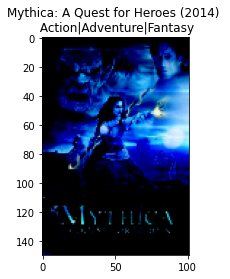

In [31]:
show_img("3405714")


In [24]:
def preprocess(img, size=(101, 150)):
    img = cv2.resize(img, size)
    img = img.astype(np.float32)
    img = (img / 127.5) - 1.
    return img


In [32]:
def prepare_data(data, img_dict, size=(150, 101)):
    print("Generation dataset...")
    dataset = []
    y = []
    ids = []
    label_dict = {"word2idx": {}, "idx2word": []}
    idx = 0
    genre_per_movie = data["Genre"].apply(lambda x: str(x).split("|"))
    for l in [g for d in genre_per_movie for g in d]:
        if l in label_dict["idx2word"]:
            pass
        else:
            label_dict["idx2word"].append(l)
            label_dict["word2idx"][l] = idx
            idx += 1
    n_classes = len(label_dict["idx2word"])
    print("identified {} classes".format(n_classes))
    n_samples = len(img_dict)
    print("got {} samples".format(n_samples))
    for k in img_dict:
        try:
            g = str(data[data["imdbId"] == int(k)]["Genre"].values[0]).split("|")
            img = preprocess(img_dict[k], size)
            
            if img.shape != (101, 150, 3):
                continue
            
            l = np.sum([np.eye(n_classes, dtype="uint8")[label_dict["word2idx"][s]] for s in g], axis=0)
            y.append(l)
            dataset.append(img)
            ids.append(k)
        except Exception as r:
            print(r)
    print("DONE")
    return dataset, y, label_dict, ids

In [33]:
SIZE = (150, 101)
dataset, y, label_dict, ids =  prepare_data(data, img_dict, size=SIZE)

Generation dataset...
identified 29 classes
got 38667 samples
DONE


In [34]:
len(dataset)

38667

In [35]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization


In [36]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(SIZE[0], SIZE[1], 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(29, activation='sigmoid'))


In [50]:
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [51]:
n = 10000
model.fit(np.array(dataset[: n]), np.array(y[: n]), batch_size=16, epochs=75,
          verbose=1, validation_split=0.1)


Epoch 1/75
563/563 [==============================] - 7s 13ms/step - loss: 0.0787 - accuracy: 0.5068 - val_loss: 0.3403 - val_accuracy: 0.2980
Epoch 2/75
563/563 [==============================] - 7s 12ms/step - loss: 0.0779 - accuracy: 0.5124 - val_loss: 0.3330 - val_accuracy: 0.2900
Epoch 3/75
563/563 [==============================] - 7s 12ms/step - loss: 0.0766 - accuracy: 0.5099 - val_loss: 0.3365 - val_accuracy: 0.2800
Epoch 4/75
563/563 [==============================] - 7s 12ms/step - loss: 0.0756 - accuracy: 0.5143 - val_loss: 0.3422 - val_accuracy: 0.2890
Epoch 5/75
563/563 [==============================] - 7s 12ms/step - loss: 0.0753 - accuracy: 0.5207 - val_loss: 0.3208 - val_accuracy: 0.2970
Epoch 6/75
563/563 [==============================] - 7s 12ms/step - loss: 0.0759 - accuracy: 0.5223 - val_loss: 0.3329 - val_accuracy: 0.2860
Epoch 7/75
563/563 [==============================] - 7s 13ms/step - loss: 0.0748 - accuracy: 0.5148 - val_loss: 0.3587 - val_accuracy: 0.2920

In [45]:
n_test = 100
X_test = dataset[n:n + n_test]
y_test = y[n:n + n_test]


pred = model.predict(np.array(X_test))


In [46]:
def show_example(idx):
    N_true = int(np.sum(y_test[idx]))
    show_img(ids[n + idx])
    print("Prediction: {}".format("|".join(["{} ({:.3})".format(label_dict["idx2word"][s], pred[idx][s])
                                            for s in pred[idx].argsort()[-N_true:][::-1]])))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(150, 101, 3)
Prediction: Comedy (0.664)|Drama (0.174)|Crime (0.0418)


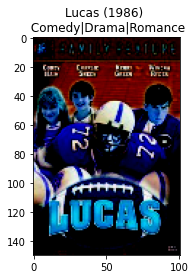

In [47]:
show_example(3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(150, 101, 3)
Prediction: Comedy (0.452)|Drama (0.409)|Romance (0.291)


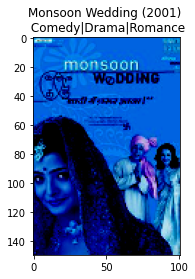

In [48]:
show_example(97)
